In [24]:
%load_ext autoreload
%autoreload 2

import utils
from visualization.simple_data_vis import histograms
import surrogate_models.dab_nn_defs as engine
import kerastuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# load data from just-private/data
filename = 'mol_res_scan_results_7.csv'
data = utils.load_data(filename)

# since currently data is just one big dataframe, select model inputs as X and purity, yield as Y
x = [*data.columns[:2],*data.columns[4:]]
y = data.columns[2:4]

In [ ]:
# _,_ = histograms(data,x,y)

In [18]:
# split data into train and test
train_x, test_x, train_y, test_y = utils.chroma_train_test_split(data, x,y)

In [19]:
train_x, test_x = utils.preprocessing([train_x, test_x], standarize = True, skip = ['cut 1','cut 2'])

In [120]:
# define Probabilistic Bayesian Neural Network
prob_bnn_model = engine.create_probablistic_bnn_model(
    FEATURE_NAMES = x,
    TARGET_NAMES = y, 
    train_size = len(train_x), 
    n_outputs = len(y),
    hidden_units = [100,],
    name = 'PBNN_'+filename
    )

# specify train/test routine 
engine.run_experiment(
    model = prob_bnn_model, 
    loss = tf.keras.metrics.MeanAbsoluteError(), 
    learning_rate = 0.001,
    num_epochs = 300,
    train_dataset = tf.data.Dataset.from_tensor_slices((train_x.to_dict('list'),train_y.to_dict('list'))).batch(len(train_x)), 
    test_dataset = tf.data.Dataset.from_tensor_slices((test_x.to_dict('list'),test_y.to_dict('list'))).batch(len(test_x)),
    verbose = 1
    )

d_mean_squared_error: 1.7297 - purity_mean_squared_error: 0.6349 - mean_absolute_error: 1.0127 - val_loss: 1.0037 - val_yield_loss: 0.5519 - val_purity_loss: 0.4269 - val_yield_mean_squared_error: 0.3620 - val_purity_mean_squared_error: 0.1335 - val_mean_absolute_error: 0.4269
Epoch 253/300
1/1 [==============================] - 0s 496ms/step - loss: 0.9700 - yield_loss: 0.5470 - purity_loss: 0.3991 - yield_mean_squared_error: 0.3567 - purity_mean_squared_error: 0.0883 - mean_absolute_error: 0.3991 - val_loss: 2.0142 - val_yield_loss: 1.1852 - val_purity_loss: 0.8049 - val_yield_mean_squared_error: 1.5226 - val_purity_mean_squared_error: 0.2162 - val_mean_absolute_error: 0.8049
Epoch 254/300
1/1 [==============================] - 1s 556ms/step - loss: 0.9999 - yield_loss: 0.4173 - purity_loss: 0.5617 - yield_mean_squared_error: 0.2345 - purity_mean_squared_error: 0.5945 - mean_absolute_error: 0.5617 - val_loss: 1.3180 - val_yield_loss: 0.5047 - val_purity_loss: 0.7902 - val_yield_mean_

In [ ]:
def model_builder(hp):
    hp_layers = hp.Int('layers', min_value=2, max_value=10)
    hp_units = hp.Int('units', min_value=4, max_value = 32, step=2)
    for L in range(hp_layers):
        hidden_units = [np.ceil(hp_units**(l/L)) for l in range(L)]

    # define Probabilistic Bayesian Neural Network 
    model = engine.create_probablistic_bnn_model(
        FEATURE_NAMES = data.columns[4:],
        TARGET_NAMES = data.columns[2:4], 
        train_size = train_size, 
        n_outputs = y.shape[1],
        hidden_units = hidden_units,
        name = 'PBNN_'+filename
        )

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss=engine.negative_loglikelihood,
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=400,
                     factor=2,
                     directory="surrogate_models/.hypertuning/",
                     project_name='intro_to_kt')

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(train_dataset, validation_data = test_dataset, epochs = 100)

In [ ]:
best = tuner.get_best_models()

In [ ]:
best_distributions = best[0](sample_inputs)
best_means = [i.mean().numpy().tolist() for i in best_distributions]


In [ ]:
best_means

Text(0, 0.5, 'predicted')

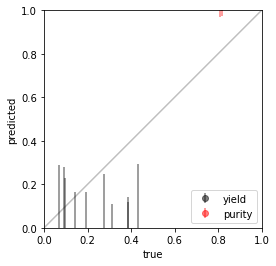

In [121]:
import matplotlib.pyplot as plt
N = 10

sample_inputs, sample_outputs = list(tf.data.Dataset.from_tensor_slices((train_x.to_dict('list'),train_y.to_dict('list'))).batch(N))[0]

out = []
for i in range(N):
    out.append(prob_bnn_model(sample_inputs))
out = tf.stack(out,-1)

colors = ['k','r']
for i in range(2):
    plt.errorbar(list(sample_outputs.values())[i].numpy(), out[i,:,:,:].numpy().mean(-1),
    yerr = out[i,:,:,:].numpy().std(-1).squeeze(),
    label = data.columns[2:4][i],
    marker = 'o', color = colors[i], alpha = 0.5,
    ls = 'none')
plt.plot([0,1],[0,1],'k',alpha=0.25)
plt.legend(loc='lower right')
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect('equal')
plt.xlabel('true')
plt.ylabel('predicted')


(<Figure size 216x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'yield'}>,
        <AxesSubplot:title={'center':'purity'}>], dtype=object))

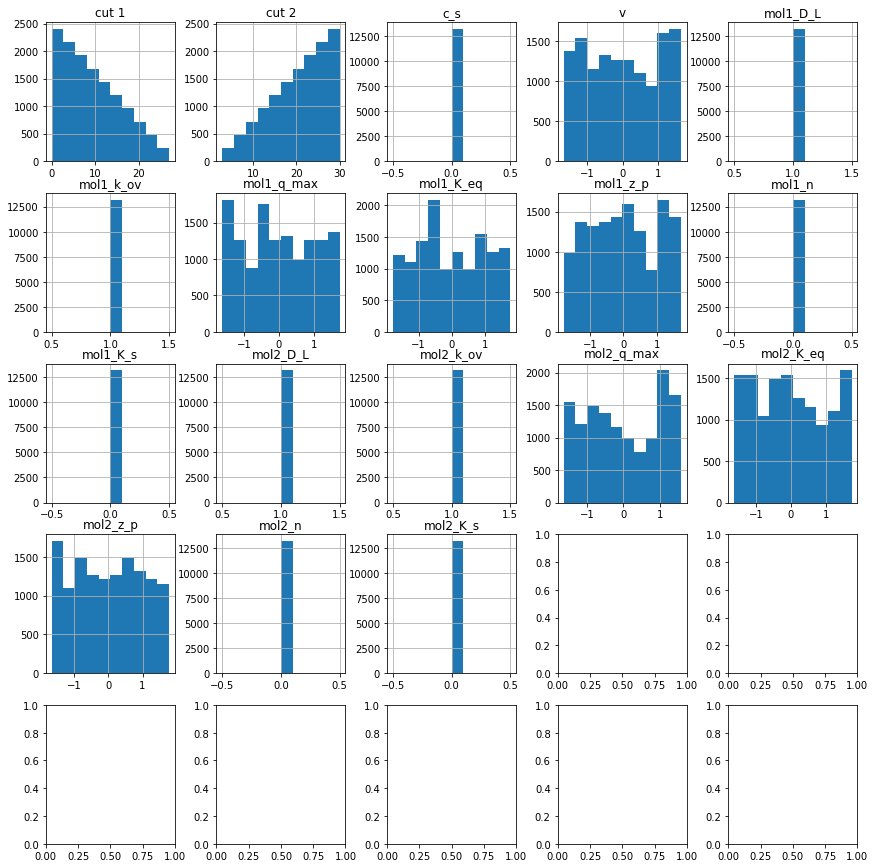

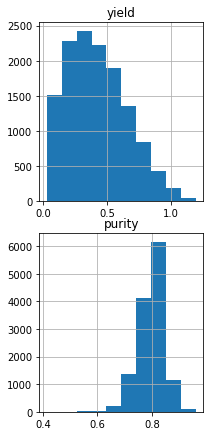

In [111]:
histograms(train_y.merge(train_x, left_index=True, right_index = True),x,y)